普通のDNNでwightが直交行列になるかをconditional numberを用いて観察する。

In [1]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

import TN_utils
reload(TN_utils)
plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

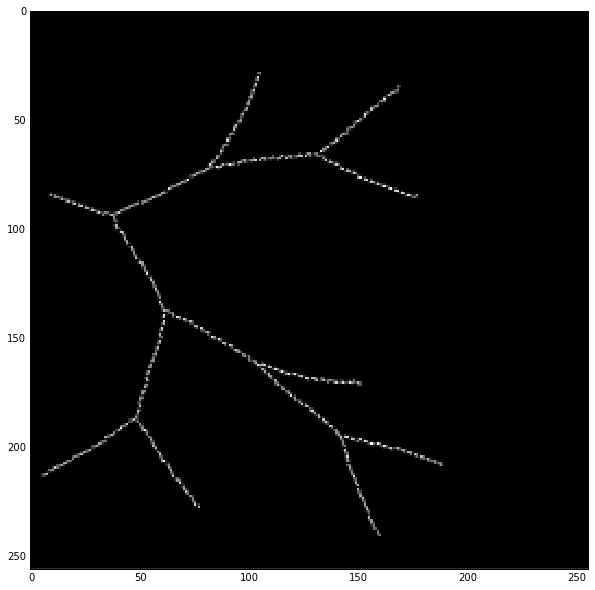

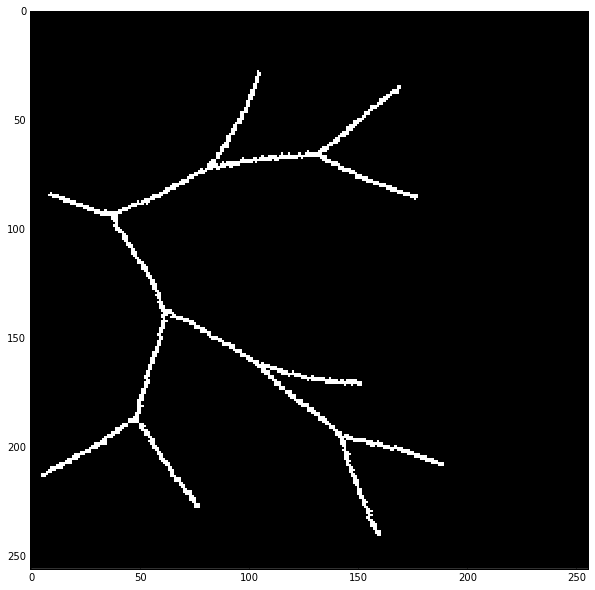

In [2]:
with gzip.open("../data/toytreerot_imgGT.npy.gz") as f:
    imGT_list = np.load(f)
imGT_list.shape
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))
for i in range(len(imGT_list)):
    index = np.linalg.norm(imGT_list[i], axis=1).nonzero()[0]
    imGT_list[i][index] = imGT_list[i][index] / np.linalg.norm(imGT_list[i], axis=1)[index][:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))

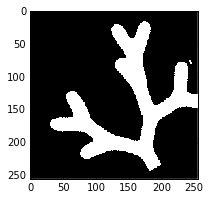

In [3]:
with gzip.open("../data/toytreerot_mask.npy.gz") as f:
    mask_list = np.load(f)
mask_list.shape
plt.figure(figsize=(3, 3))
plt.imshow(mask_list[20].reshape(256, 256))

In [4]:
featureImg_list = []
for i in range(1, 37):
    print i
    matlab_struct = sio.loadmat('../data/featureImgr' + str(i) + '.mat')
    featureImg = matlab_struct['f']

    # 複素数からベクトルへの変換
    featureImg_vec = np.zeros((featureImg.shape[0], 12, 2))
    featureImg_vec[:, :, 0] = np.real(featureImg[:, 12:24])
    featureImg_vec[:,:,1] = np.imag(featureImg[:, 12:24])
    featureImg_list.append(featureImg_vec)

print featureImg.dtype, featureImg_list[1].shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
complex128 (65536, 12, 2)


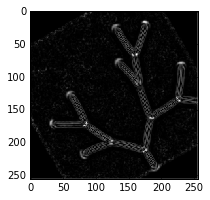

In [5]:
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(featureImg_list[20][:, 5], axis=1).reshape(256, 256))

In [6]:
m_featureImg_list = [featureImg_list[i][mask_list[i]] for i in range(36)]
m_imgGT_list = [imGT_list[i][mask_list[i]] for i in range(36)]

In [7]:
m_feature_t1 = m_featureImg_list[35]
m_GT_t1 = m_imgGT_list[35]
m_feature_t1.shape, m_GT_t1.shape

((14138, 12, 2), (14138, 2))

In [8]:
range(0, 36, 3)

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]

In [9]:
# 10, 40, 70, 130, ...340の12サンプル
m_feature_t12 = np.concatenate([m_featureImg_list[i] for i in range(0, 36, 3)], axis=0)
m_GT_t12 = np.concatenate([m_imgGT_list[i] for i in range(0, 36, 3)], axis=0)
print m_feature_t12.shape, m_GT_t12.shape

(166492, 12, 2) (166492, 2)


In [10]:
m_feature_t36 = np.concatenate([m_featureImg_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
m_GT_t36 = np.concatenate([m_imgGT_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
print m_feature_t36.shape, m_GT_t36.shape

(485423, 12, 2) (485423, 2)


In [11]:
m_feature_vec120 = m_featureImg_list[11]
m_GT_vec120 = m_imgGT_list[11]

In [12]:
activation_list = ["sigm", "ReLU"]
n_tensors = 12
dim = 2
n_hidden = 10
param_list = [0.01 * np.random.normal(size=(n_tensors*dim, n_hidden)), np.zeros(n_hidden),
              0.01 * np.random.normal(size=(n_hidden, dim)), np.zeros(dim)]

In [13]:
import theano_dnn
reload(theano_dnn)

Couldn't import dot_parser, loading of dot files will not be possible.


<module 'theano_dnn' from 'theano_dnn.pyc'>

In [14]:
vnn = theano_dnn.VnnClf(m_feature_t1, m_GT_t1,
                         m_feature_vec120, m_GT_vec120,
                         param_list, ["w1", "b1", "w2", "b2"],
                        activation_list,
                       [2, 2])

In [15]:
vnn.initialize_params(param_list)

In [18]:

vnn.set_training(feature_list[1], GT_list[1]) 

In [19]:
batch_size = 100
l2 = 0.

n_batchs = vnn.n_pixels // batch_size
        
n_epochs = epoch_list[1]
interval = n_epochs // 30
training_MSE_array = np.zeros(n_epochs // interval)
test_MSE_array = np.zeros(n_epochs // interval)

In [20]:
cn_list_list = []
weighted_sum_list = []
lr = lr_list[1]
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        vnn.train(i_batch, lr, l2, batch_size)

    if i_epoch % interval == 0:
        MSE = vnn.training_error()
        training_MSE_array[i_epoch // interval] = MSE
        MSE = vnn.test_error()
        test_MSE_array[i_epoch // interval] = MSE

        w_list = vnn.get_w_list()
        cn_list = []
        for aw in w_list:
            cn_list.append(TN_utils.clcl_cn_inv(aw))
        cn_list_list.append(cn_list)
        w_norm_list = np.asarray([np.sum(w**2) for w in w_list])
        weighted_sum = np.sum(np.asarray(cn_list) * np.asarray(w_norm_list))
        n_weighted_sum = weighted_sum / np.sum(w_norm_list)
        weighted_sum_list.append(n_weighted_sum)

        print i_epoch, MSE

0 0.0470122675618
6 0.0292584403563
12 0.0209758121445
18 0.0176257850003
24 0.0160402897814
30 0.015144336033
36 0.0145718251056
42 0.0141997716611
48 0.0139357143547
54 0.0138023515767
60 0.0137096240641
66 0.0136280989292
72 0.0136068057122
78 0.013538718569
84 0.0135264842741
90 0.0134871866224
96 0.0134577273494
102 0.0134755542718
108 0.0134451824641
114 0.0134282957533
120 0.0134103146981
126 0.0134121080313
132 0.0134139088686
138 0.0134151739993
144 0.0134042644305
150 0.0134115579475
156 0.0134086806283
162 0.0134050650547
168 0.0134504814297
174 0.0133987089309


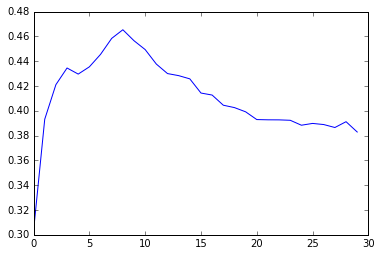

In [21]:
plt.plot(np.mean(cn_list_list, axis=1))

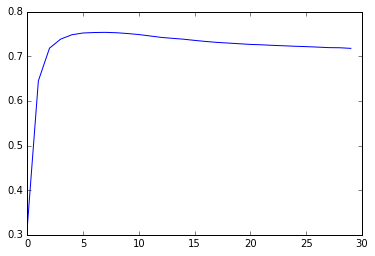

In [22]:
# まじか
plt.plot(weighted_sum_list)

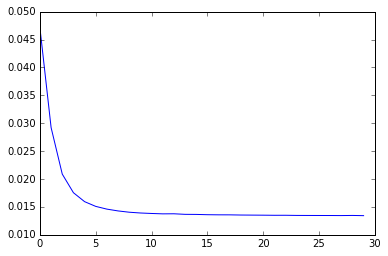

In [23]:
plt.plot(training_MSE_array)

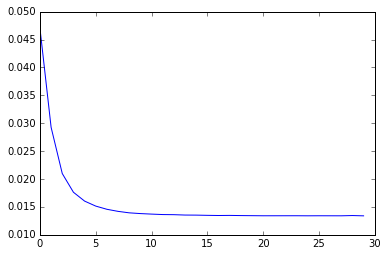

In [24]:
plt.plot(test_MSE_array)

In [25]:
import cond_num_dnn_ex
reload(cond_num_dnn_ex)

<module 'cond_num_dnn_ex' from 'cond_num_dnn_ex.pyc'>

In [26]:
feature_list =[m_feature_t1, m_feature_t12, m_feature_t36]
GT_list = [m_GT_t1, m_GT_t12, m_GT_t36]
epoch_list = [2160, 180, 60]
lr_list = [0.0005, 0.0005, 0.0005]

In [27]:
results = cond_num_dnn_ex.cond_num_dnn_ex(vnn, param_list, feature_list, GT_list, 
                                          lr_list, epoch_list, featureImg_list)

0 0.0520019384355
144 0.0306035331381
288 0.0243968068544
432 0.0221426037607
576 0.0208514970626
720 0.0201852321923
864 0.0200336421275
1008 0.0199107212246
1152 0.0195885708868
1296 0.0194850859414
1440 0.019395466244
1584 0.0193746735751
1728 0.0191935922136
1872 0.0191090156573
2016 0.0191904205862
0 0.0470122675618
12 0.0209758121445
24 0.0160402897814
36 0.0145718251056
48 0.0139357143547
60 0.0137096240641
72 0.0136068057122
84 0.0135264842741
96 0.0134577273494
108 0.0134451824641
120 0.0134103146981
132 0.0134139088686
144 0.0134042644305
156 0.0134086806283
168 0.0134504814297
0 0.0408883038992
4 0.0208304441723
8 0.0161287431697
12 0.014579480533
16 0.0140444210358
20 0.0137211308734
24 0.0135716480718
28 0.0134467929547
32 0.0133571518861
36 0.0132931565768
40 0.0132342950771
44 0.0132153969986
48 0.0132026366242
52 0.013235481262
56 0.0131722374495


In [28]:
train_error_list, test_error_list, cn11236, wsc11236, gt1img360_list, gt1img120_list = results

In [30]:
namelist = ["train_error_list", "test_error_list", "cn11236", "wsc11236", "gt1img360_list", "gt1img120_list"]
for data, name in zip(results, namelist):
    with gzip.open("../results/CondNumDNNsigm/"+name+".npy.gz", "w") as f:
        np.save(f, data)

In [31]:
sio.savemat('../results/CondNumDNNsigm/v_train360_list.mat', {'v_train360_list': gt1img360_list})
sio.savemat('../results/CondNumDNNsigm/v_train120_list.mat', {'v_train120_list': gt1img120_list})

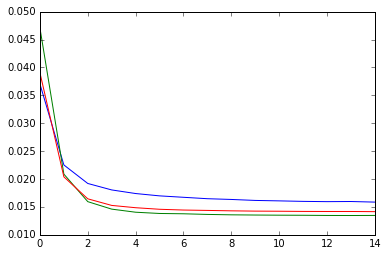

In [32]:
for i in range(3):    
    plt.plot(train_error_list[i])

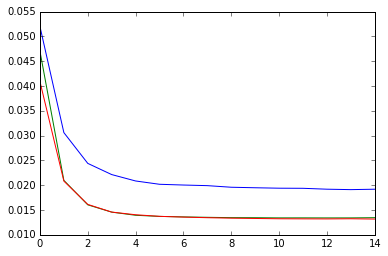

In [33]:
for i in range(3): 
    plt.plot(test_error_list[i])

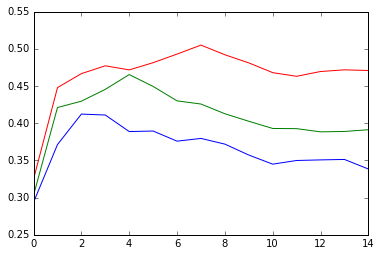

In [34]:
for i in range(3):
    plt.plot(np.mean(cn11236[i], axis=1))

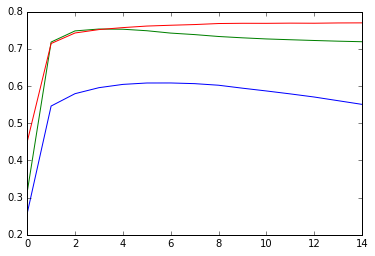

In [35]:
for i in range(3):    
    plt.plot(wsc11236[i])

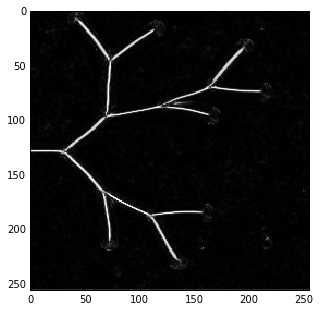

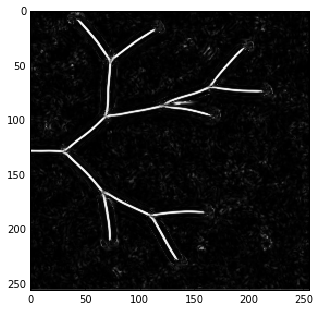

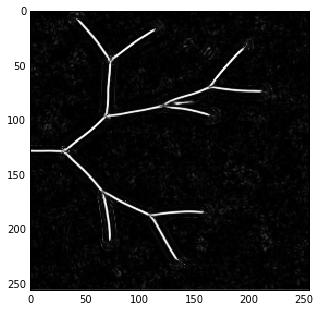

In [36]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img360_list[i], axis=0))

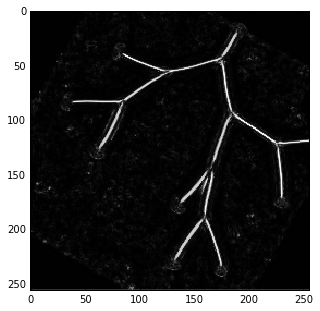

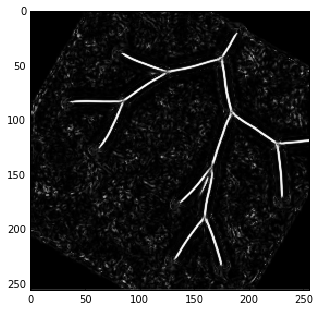

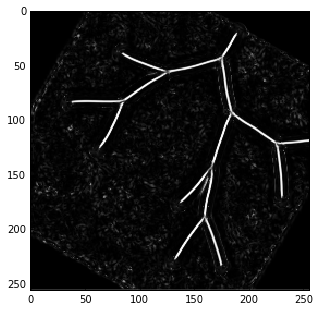

In [37]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img120_list[i], axis=0))